# Assignment 3

### Environment Setup

In [29]:
import numpy as np
import pandas as pd
from scipy.io import loadmat
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage,dendrogram,fcluster
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import csv

from typing import TypeAlias

# reads dataset into numpy array
def getDataset():
  with open('./data_clustering.csv', 'r') as f:
    reader = csv.reader(f)
    data = list(reader)
    data_array = np.array(data, dtype=float)
    return data_array


In [30]:
# show file contents
!cat ./data_clustering.csv | head

0.32090430934665926,0.8572882283668262
0.119262314052953,0.5777166416197385
0.10684087406768455,0.7418910976942216
0.45444762940979105,0.28754424614274443
0.44867379605213037,0.22753405529728424
0.15201127863227806,0.7467463137487926
0.6149140418627035,0.41799262281699684
0.4721947662187688,0.2461298307352894
0.6699493143254428,0.42967709562071554
0.42485312416848975,0.6499243122793389


## Implementation of the DBSCAN algorithm and helper methods

In [31]:
from numpy.ma.core import sqrt
# helper functions
from itertools import chain


# works for n-dimensional points too
def euclidean_distance(p1, p2):
    vals = list(zip(p1, p2))
    return sum(map(lambda x: (x[0]-x[1])**2, vals)) ** 0.5


# return neighbors (index, point) in radius eps including P
def regionQuery(D, P, eps):
  N = []
  for i, p in enumerate(D):
    distance = euclidean_distance(p, P)
    if distance <= eps:
      N.append( (i,p) )
  return N

Point = tuple[int,np.array(float)]

def expandCluster(P: Point, NeighborPts, C, eps, minPts, clusters, visited):
  idx, _ = P
  for i, p in NeighborPts:
    # expand possible points for this cluster
    if not visited[i]:
      visited[i] = True
      neighs = regionQuery(D, p, eps)
      if len(neighs) >= minPts:
        NeighborPts += neighs
    # add point to cluster
    if i not in list(chain.from_iterable(clusters)):
      C.append(i)

Noise : TypeAlias = list[int]
Cluster  : TypeAlias = list[int] # first element is the clusters orgigin
DBSCANResult : TypeAlias = tuple[Noise, list[Cluster]]
# dbscan algorithm
def DBSCAN(D, eps, minPts) -> DBSCANResult:
  visited = [False] * len(D) # allocate predefined length every node has to be visited
  noise = []
  clusters = []
  for i, p in enumerate(D):
    if visited[i]: continue
    visited[i] = True
    # assert: p is unvisited
    neighs = regionQuery(D, p, eps)
    is_core_point = len(neighs) >= minPts
    if is_core_point:
      C = [i] # new cluster (ID is just its index in the clusters list, or the first element being the starting core point id)
      clusters.append(C)
      expandCluster((i,p),neighs,C,eps,minPts,clusters,visited) #expand from p as long as possible
      # then continue with next unvisited point
      # until all points have either formed a cluster, joined a cluster (corepoints)
      # or "joined" the noise
      # border points? they are also joined to clusters in expand because they are included in the corepoints neighbors
      # but border points will not contribute to expanding the cluster any further
    else:
      noise.append(i)

  return (noise, clusters)



In [32]:
D = getDataset()
print(len(D))
print(D[:10])

200
[[0.32090431 0.85728823]
 [0.11926231 0.57771664]
 [0.10684087 0.7418911 ]
 [0.45444763 0.28754425]
 [0.4486738  0.22753406]
 [0.15201128 0.74674631]
 [0.61491404 0.41799262]
 [0.47219477 0.24612983]
 [0.66994931 0.4296771 ]
 [0.42485312 0.64992431]]


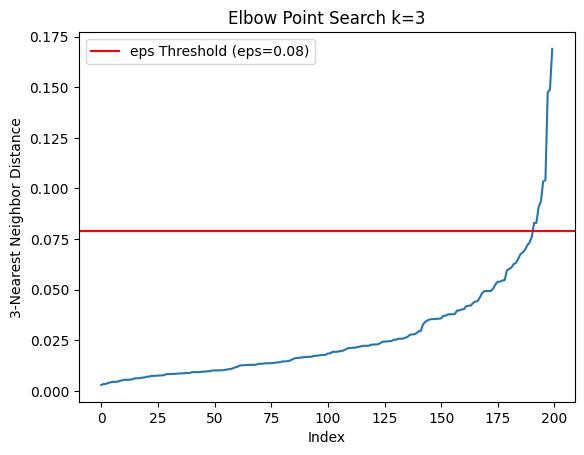

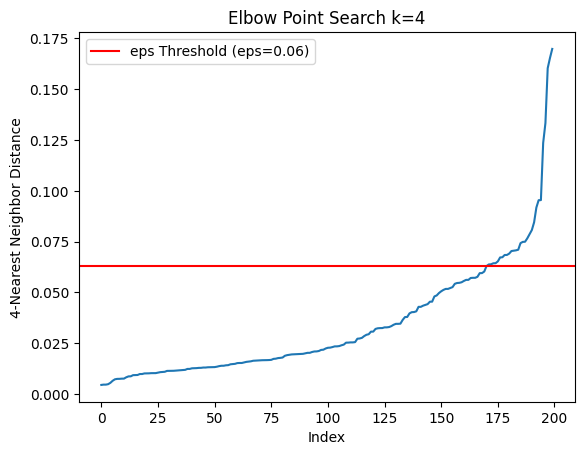

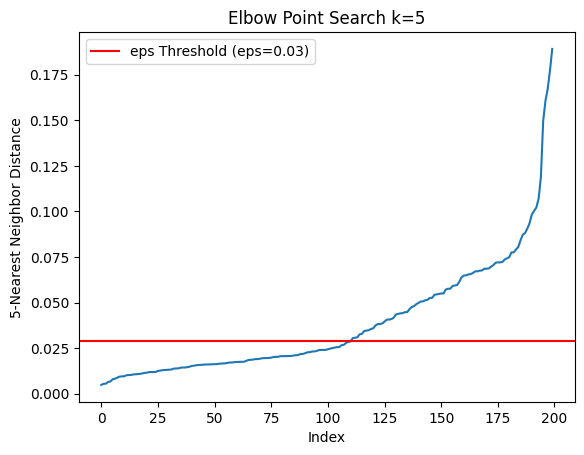

In [33]:
#KNN
from sklearn.neighbors import NearestNeighbors

n=3
neigh = NearestNeighbors(n_neighbors=n).fit(D)
distances = neigh.kneighbors(D)[0]
distances = np.sort(distances[:, -1])

#Choose the point
eps_threshold = 0.079

plt.plot(distances)
plt.axhline(y=eps_threshold, color='r', label=f'eps Threshold (eps={eps_threshold:.2f})')
plt.xlabel('Index')
plt.ylabel(f'{n}-Nearest Neighbor Distance')
plt.title(f'Elbow Point Search k={n}')
plt.legend()
plt.show()

n=4
neigh = NearestNeighbors(n_neighbors=n).fit(D)
distances = neigh.kneighbors(D)[0]
distances = np.sort(distances[:, -1])

#Choose the point
eps_threshold = 0.063

plt.plot(distances)
plt.axhline(y=eps_threshold, color='r', label=f'eps Threshold (eps={eps_threshold:.2f})')
plt.xlabel('Index')
plt.ylabel(f'{n}-Nearest Neighbor Distance')
plt.title(f'Elbow Point Search k={n}')
plt.legend()
plt.show()

n=5
neigh = NearestNeighbors(n_neighbors=n).fit(D)
distances = neigh.kneighbors(D)[0]
distances = np.sort(distances[:, -1])

#Choose the point
eps_threshold = 0.029

plt.plot(distances)
plt.axhline(y=eps_threshold, color='r', label=f'eps Threshold (eps={eps_threshold:.2f})')
plt.xlabel('Index')
plt.ylabel(f'{n}-Nearest Neighbor Distance')
plt.title(f'Elbow Point Search k={n}')
plt.legend()
plt.show()

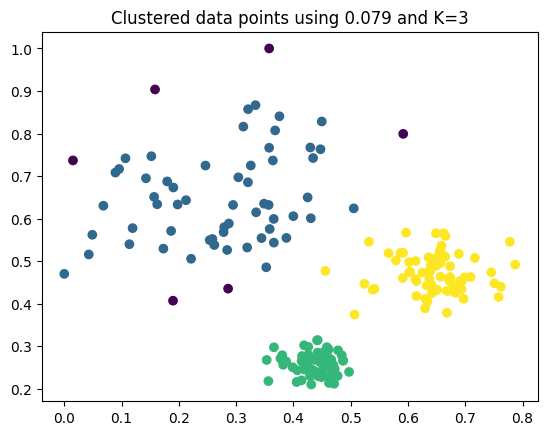

SCORE= 0.6062333578112429


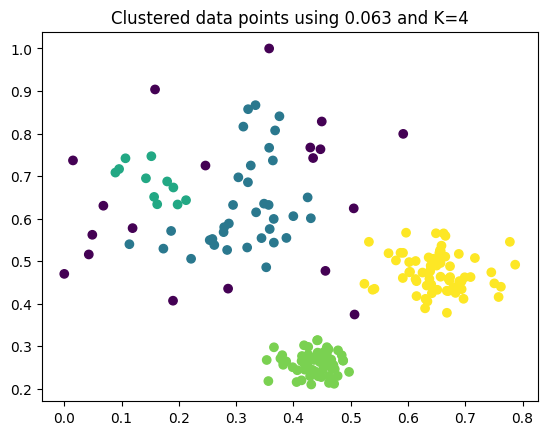

SCORE= 0.5585666343542399


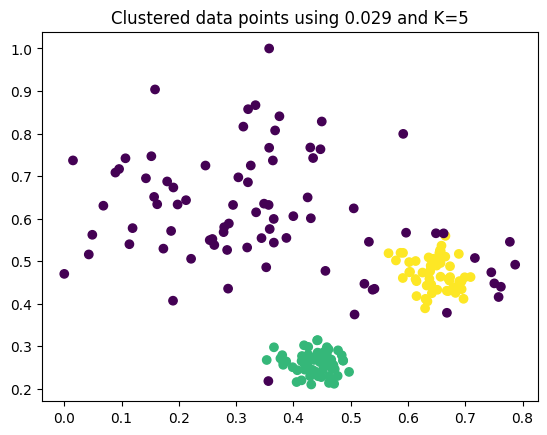

SCORE= 0.520060869065577


In [34]:
#Plot and score
eps = 0.079
minPts = 3
res = DBSCAN(D, eps, minPts)
clusters = res[1]
coloring = [0] * 200

color=0
for cluster_no in clusters:
  color+=1
  for cluster_index in cluster_no:
      coloring[cluster_index] = color

plt.scatter(D[:, 0], D[:, 1],c=coloring, cmap='viridis')
plt.title(f"Clustered data points using {eps} and K={minPts}")
plt.show()
silhouette_avg = silhouette_score(D, coloring)
print(f"SCORE= {silhouette_avg}")

eps = 0.063
minPts = 4
res = DBSCAN(D, eps, minPts)
clusters = res[1]
coloring = [0] * 200

color=1
for cluster_no in clusters:
  color+=1
  for cluster_index in cluster_no:
      coloring[cluster_index] = color

plt.scatter(D[:, 0], D[:, 1],c=coloring, cmap='viridis')
plt.title(f"Clustered data points using {eps} and K={minPts}")
plt.show()
silhouette_avg = silhouette_score(D, coloring)
print(f"SCORE= {silhouette_avg}")

eps = 0.029
minPts = 5
res = DBSCAN(D, eps, minPts)
clusters = res[1]
coloring = [0] * 200

color=1
for cluster_no in clusters:
  color+=1
  for cluster_index in cluster_no:
      coloring[cluster_index] = color

plt.scatter(D[:, 0], D[:, 1],c=coloring, cmap='viridis')
plt.title(f"Clustered data points using {eps} and K={minPts}")
plt.show()
silhouette_avg = silhouette_score(D, coloring)
print(f"SCORE= {silhouette_avg}")

In [36]:
import numpy as np
import pandas as pd
from scipy.io import loadmat
from sklearn import metrics

# reads dataset into numpy array
def getDatasetThyroid():
    mat = loadmat("thyroid.mat")
    return mat

In [37]:
D_thyroid = getDatasetThyroid()

In [38]:
vals = D_thyroid['X']
labels = D_thyroid['y']

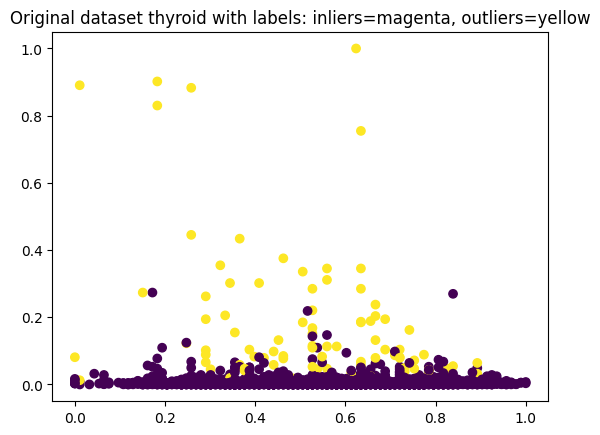

In [47]:
# plot original dataset (magenta = outliers, yellow = inliers)
plt.scatter(vals[:, 0], vals[:, 1],c=labels, cmap='viridis')
plt.title("Original dataset thyroid with labels: inliers=magenta, outliers=yellow")
plt.show()

In [48]:
#KNN
from sklearn.neighbors import NearestNeighbors

def showElbow(D, K, eps_threshold):
  #KNN
  neigh = NearestNeighbors(n_neighbors=K)
  neigh.fit(D)
  distances= neigh.kneighbors(D)[0]
  distances = np.sort(distances[:, -1])

  plt.plot(distances)
  plt.axhline(y=eps_threshold, color='r', label=f'eps Threshold (eps={eps_threshold:.2f})')
  plt.xlabel('Index')
  plt.ylabel(f'{K}-Nearest Neighbor Distance')
  plt.title(f'Elbow Point Search k={K}')
  plt.legend()
  plt.show()

In [49]:

def showScatterRes(res, vals, K, eps):
  labels= [0] * len(vals)
  for i in res[0]:
      labels[i] = 1 # outliers

  for c in res[1]:
      for i in c:
          labels[i] = 0 # inliers

  plt.scatter(vals[:, 0], vals[:, 1],c=labels, cmap='viridis')
  plt.ylabel(f'Scatterplot colored data inliers=magenta, outliers=yellow')
  plt.title(f'Scatterplot cluster data colored k={K} eps={eps}')
  plt.show()

In [50]:
def printQuantitativeStats(res, vals):
    res_labels= [0] * len(vals)
    for i in res[0]:
        res_labels[i] = 1 # outliers

    for c in res[1]:
        for i in c:
            res_labels[i] = 0 # inliers

    precision = metrics.precision_score(labels, res_labels)
    recall = metrics.recall_score(labels, res_labels)
    f_score = metrics.f1_score(labels, res_labels)

    print("Precision:", precision)
    print("Recall:", recall)
    print("F-score:", f_score)

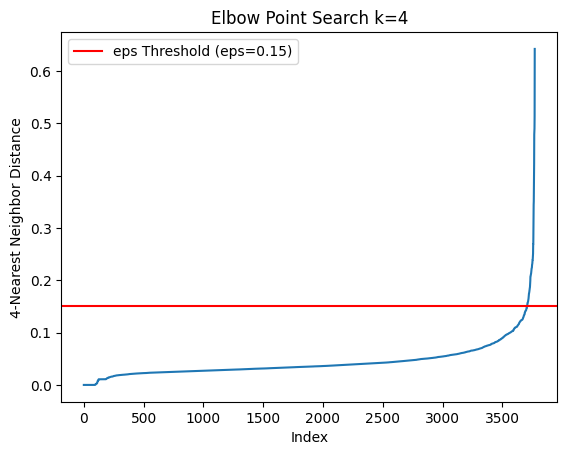

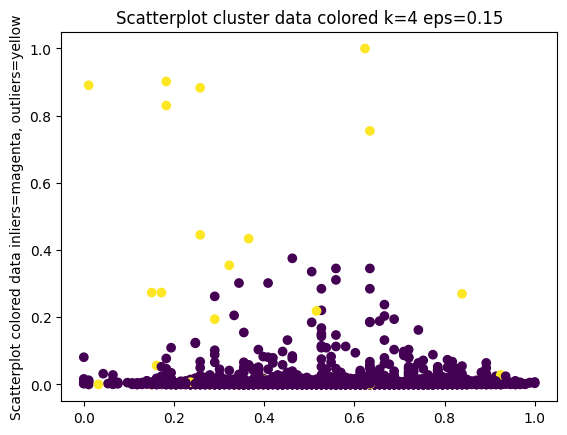

Precision: 0.20754716981132076
Recall: 0.11827956989247312
F-score: 0.15068493150684933


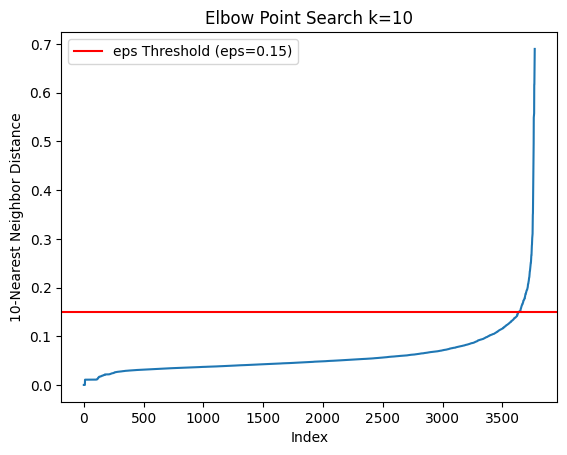

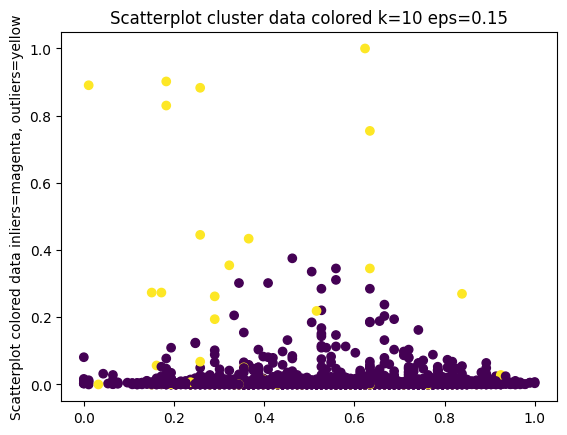

Precision: 0.17073170731707318
Recall: 0.15053763440860216
F-score: 0.16


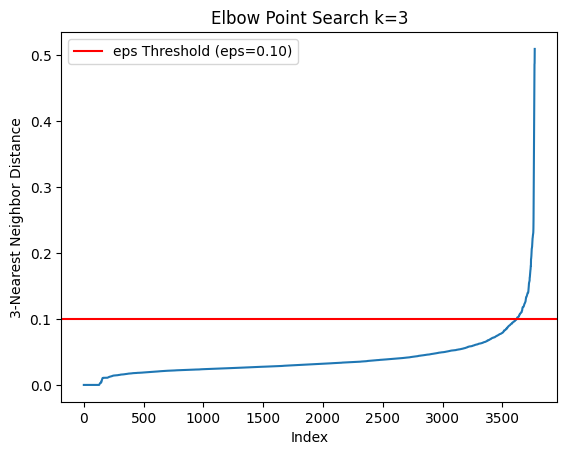

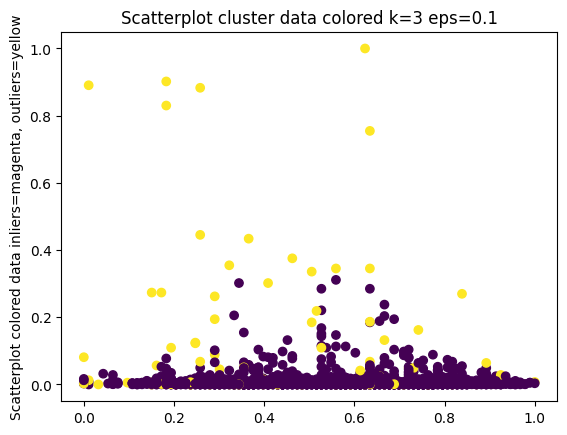

Precision: 0.256
Recall: 0.34408602150537637
F-score: 0.29357798165137616


In [51]:
K=4
eps = 0.15
showElbow(vals, K, eps)
res = DBSCAN(vals, eps, K)
showScatterRes(res, vals, K, eps)
printQuantitativeStats(res, vals)


K=10
eps = 0.15
showElbow(vals, K, eps)
res = DBSCAN(vals, eps, K)
showScatterRes(res, vals, K,eps)
printQuantitativeStats(res, vals)

K=3
eps = 0.1
showElbow(vals, K,eps)
res = DBSCAN(vals, eps, K)
showScatterRes(res, vals, K, eps)
printQuantitativeStats(res, vals)